In [1]:
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics.classification import MulticlassAccuracy
from sklearn.model_selection import train_test_split

from transformers import BertModel, RobertaTokenizer, BertTokenizer, RobertaTokenizerFast
from tqdm import tqdm

import matplotlib.pyplot as plt
from collections import Counter

/home/andrewkim/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Utils

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
def my_topk_accuracy(preds,targets,topk,ignore_idx,num_classes):

    topk_indices = torch.topk(preds, topk, dim=1)[1]
    topk_indices = topk_indices.cpu()
    targets = targets.cpu()
    total_correct = 0
    total_count = 0
    for i in range(targets.shape[0]):
        if targets[i] == ignore_idx:
            continue
        if targets[i] in topk_indices[i]:
            total_correct += 1
        total_count += 1
    if total_count == 0:
        print("debug target")
        print(targets)
    accuracy = total_correct / total_count
    return accuracy

def torch_metrics_accuracy(preds,targets,ignore_idx,num_classes):
    preds = preds.cpu()
    targets = targets.cpu()
    accuracy_obj = MulticlassAccuracy(num_classes,
                                      average='micro',
                                      ignore_index=ignore_idx)
    accuracy = accuracy_obj(preds, targets)
    return accuracy

### Hyperparameters / Datapath

In [4]:
perform_inference = False
dropout = 0.25
batch_size = 4
epochs = 30
lr = 0.0001
distance_mask_token = 2
no_mask_token = 1
max_len = 371
bert_max_len = 373

#data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_edry_class.npy'
data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_cwxp_class.npy'
#data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_npxxy_class.npy'
#data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_mask5_class.npy'
#data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_mask10_class.npy'
#data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_mask15_class.npy'
#data_path = '/home/andrewkim/Desktop/GPCRBert/data/final_mask50_class.npy'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/proteins_EDRY.pt'
save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/proteins_CWXP.pt'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/proteins_NPXXY.pt'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/proteins_mask5.pt'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/proteins_mask10.pt'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/proteins_mask15.pt'
#save_path = '/home/andrewkim/Desktop/GPCRBert/parameter/proteins_mask50.pt'

## Tokenization

### 1

In [5]:
### EXPERIMENT

data = np.load(data_path, allow_pickle=True)
pdb = data[0][0]
seq = list(data[0][1]) # inputfull
seq_join = ''.join(seq) # input_full_str
pad_start = len(seq_join) + 1 # +1 for the [CLS] token

# findind start and end of req_pre_string
motif = data[0][2] # req_pre
motif_join = ''.join(motif) # requ_pre_str
start_idx = seq_join.find(motif_join)
end_idx = start_idx + 1

seq_list = list(seq_join)
seq_list[start_idx + distance_mask_token : start_idx + distance_mask_token + no_mask_token] = 'J' * no_mask_token
label_list = list(seq_join)
label_list[:start_idx+distance_mask_token] = 'J'*len(label_list[:start_idx+distance_mask_token])
label_list[start_idx+distance_mask_token+no_mask_token:] = 'J'*len(label_list[start_idx+distance_mask_token+no_mask_token:])

seq_list_spaced = ' '.join(seq_list)
label_list_spaced = ' '.join(label_list)
print(seq_list_spaced)
print(label_list_spaced)
seq_list_spaced = seq_list_spaced.replace('J', '[MASK]')
label_list_spaced = label_list_spaced.replace('J', '[MASK]')

tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert')
seq_tokenized = tokenizer(seq_list_spaced, return_tensors='pt', padding='max_length', max_length=bert_max_len)
label_tokenized = tokenizer(label_list_spaced, return_tensors='pt', padding='max_length', max_length=bert_max_len)

label_tokenized['input_ids'][label_tokenized['input_ids'] == 4] = 0
label_tokenized['input_ids'][label_tokenized['input_ids'] == 3] = 0
label_tokenized['input_ids'][label_tokenized['input_ids'] == 2] = 0
label_tokenized['input_ids'][label_tokenized['input_ids'] == 1] = 0

# convert attention of mask to 0 in input_tokenized which is 4
seq_tokenized['attention_mask'][seq_tokenized['input_ids'] == 4] = 0

seq_vocab = tokenizer.convert_ids_to_tokens(seq_tokenized['input_ids'][0])
label_vocab = tokenizer.convert_ids_to_tokens(label_tokenized['input_ids'][0])

'''
'''

A A D E V W V V G M G I V M S L I V L A I V F G N V L V I T A I A K F E R L Q T V T N Y F I T S L A C A D L V M G L A V V P F G A A C I L T K T W T F G N F W C E F W T S I D V L C V T A S I E T L C V I A V D R Y F A I T S P F K Y Q S L L T K N K A R V I I L M V W I V S G L T S F L P I Q M H W Y R A T H Q E A I N C Y A E E T C C D F F T N Q A Y A I A S S I V S F Y V P L V I M V F V Y S R V F Q E A K R Q L Q X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X X K F A L K E H K A L K T L G I I M G T F T L C W J P F F I V N I V H V I Q D N L I R K E V Y I L L N W I G Y V N S G F N P L I Y C R S P D F R I A F Q E L L C L
J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J J 

'\n'

In [6]:
label_tokenized['input_ids'][0].shape

torch.Size([373])

In [7]:
class PositionPredictionFullDataset(torch.utils.data.Dataset):

    def __init__(self,df) -> None:
        super().__init__()
        self.df = df
        self.tokenizer = BertTokenizer.from_pretrained('Rostlab/prot_bert')
        print(f"vocabulary {self.tokenizer.vocab}")

        # # finding an alphabet that is not in the vocabulary
        # capital_letters = [chr(i) for i in range(ord('A'), ord('Z')+1)]
        # for letter in capital_letters:
        #     if letter not in self.tokenizer.vocab:
        #         print(f"letter {letter} not in vocabulary")

        self.max_len = max_len
        self.bert_max_len = bert_max_len
        self.my_mask_token = 'J'
        self.bert_mask_token = '[MASK]'
        #self.req_pre_string = 'P'
        self.distance_mask_token = distance_mask_token
        self.no_mask_token = no_mask_token

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        seq = list(self.df[idx][1]) # inputfull
        seq_join = ''.join(seq) # input_full_str
        pad_start = len(seq_join) + 1 # +1 for the [CLS] token

        # findind start and end of req_pre_string
        motif = self.df[idx][2] # req_pre
        motif_join = ''.join(motif) # requ_pre_str
        start_idx = seq_join.find(motif_join)
        end_idx = start_idx + self.distance_mask_token + self.no_mask_token

        # replacing the two positions with mask token
        seq_list = list(seq_join)
        seq_list[start_idx + self.distance_mask_token : start_idx + self.distance_mask_token + self.no_mask_token] = self.my_mask_token * self.no_mask_token
        label_list = list(seq_join)
        label_list[:start_idx+self.distance_mask_token] = self.my_mask_token*len(label_list[:start_idx+self.distance_mask_token])
        label_list[start_idx+self.distance_mask_token+self.no_mask_token:] = self.my_mask_token*len(label_list[start_idx+self.distance_mask_token+self.no_mask_token:])

        seq_list_spaced = ' '.join(seq_list)
        label_list_spaced = ' '.join(label_list)

        seq_list_spaced = seq_list_spaced.replace(self.my_mask_token, self.bert_mask_token)
        seq_tokenized = self.tokenizer(seq_list_spaced, return_tensors='pt', padding='max_length', max_length=self.bert_max_len)

        label_list_spaced = label_list_spaced.replace(self.my_mask_token, self.bert_mask_token)
        label_tokenized = self.tokenizer(label_list_spaced, return_tensors='pt', padding='max_length', max_length=self.bert_max_len)

        # convert label_full_tokenized to 4 to 0 (??)
        label_tokenized['input_ids'][label_tokenized['input_ids'] == 4] = 0
        label_tokenized['input_ids'][label_tokenized['input_ids'] == 3] = 0
        label_tokenized['input_ids'][label_tokenized['input_ids'] == 2] = 0
        label_tokenized['input_ids'][label_tokenized['input_ids'] == 1] = 0

        # convert attention of mask to 0 in input_tokenized which is 4
        seq_tokenized['attention_mask'][seq_tokenized['input_ids'] == 4] = 0
        # print(label_tokenized['input_ids'])
        seq_vocab = self.tokenizer.convert_ids_to_tokens(seq_tokenized['input_ids'][0])
        label_vocab = self.tokenizer.convert_ids_to_tokens(label_tokenized['input_ids'][0])

        return seq_tokenized, label_tokenized, start_idx+self.distance_mask_token+1, end_idx+1

## Model

In [8]:
class ClassificationTwoPositionsBert(nn.Module):
    def __init__(self) -> None:
        super(ClassificationTwoPositionsBert, self).__init__()
        self.encoder = BertModel.from_pretrained('Rostlab/prot_bert', output_attentions=True if perform_inference else False)

        for key, value in self.encoder.encoder.named_parameters():
            layer_num = int(key.split('.')[1])
            if layer_num < 23:
                value.requires_grad = False

        self.fc = nn.Sequential(nn.Linear(1024,256),
                                nn.ReLU(),
                                nn.Dropout(dropout),
                                nn.Linear(256,30))

    def forward(self, input_tokens):
        # input_tokens: {input_ids, attention_mask, token_type_ids}
        encoded_features = self.encoder(**input_tokens)['last_hidden_state']
        # N*embedding_length*30
        logits = self.fc(encoded_features)
        logits = torch.permute(logits, (0, 2, 1))
        return logits # N*30*embedding_length

    def forward_test(self, input_tokens):
        # input_tokens: {input_ids, attention_mask, token_type_ids}
        encoded = self.encoder(**input_tokens)
        encoded_features = encoded['last_hidden_state'] # N*max_len*hidden_dims
        attentions = encoded['attentions']
        logits = self.fc(encoded_features)
        logits = torch.permute(logits, (0, 2, 1))
        return logits, attentions # N*classes*max_len, N*num_heads*max_len*max_len

## Train / Test

### 1

In [9]:
def train_forward_two_position_prediction(model,data_loader,optimizer,loss_fn,device):

    model = model.train()
    total_loss = 0
    total_count = 0
    total_gts = torch.zeros((0), dtype=torch.long).to(device)
    # total_preds = torch.zeros((0), dtype=torch.long).to(device)
    total_logits = torch.zeros((0, 30), dtype=torch.float).to(device)
    loop = tqdm(data_loader, leave=True, total=len(data_loader), colour='green')

    for idx, batch in enumerate(loop):
        input_tokens, label_tokens, start_idx, end_idx = batch



        input_tokens['input_ids'] = input_tokens['input_ids'].to(device).squeeze(1)
        input_tokens['token_type_ids'] = input_tokens['token_type_ids'].to(device).squeeze(1)
        input_tokens['attention_mask'] = input_tokens['attention_mask'].to(device).squeeze(1)

        label_tokens['input_ids'] = label_tokens['input_ids'].to(device).squeeze(1)
        label_tokens['token_type_ids'] = label_tokens['token_type_ids'].to(device).squeeze(1)
        label_tokens['attention_mask'] = label_tokens['attention_mask'].to(device).squeeze(1)

        out = model(input_tokens)# (batch_size, res (1~30), embedding_len)
        #print(f'out: {out.shape}')
        #print(out)
        #ltid = label_tokens['input_ids']
        #print(f'label_tokens : {ltid.shape}')
        #print(torch.max(ltid))
        iteration_loss = loss_fn(out, label_tokens['input_ids'])

        optimizer.zero_grad()
        iteration_loss.backward()
        optimizer.step()

        total_loss += iteration_loss.item() * input_tokens['input_ids'].shape[0]
        total_count += input_tokens['input_ids'].shape[0]
        out = out.permute(0, 2, 1) # (batch_size, embedding_len, res (1~30))

        for b_idx in range(out.shape[0]):

            for seq_idx in range(start_idx[b_idx], end_idx[b_idx]):
                # print(seq_idx)
                total_logits = torch.cat((total_logits, out[b_idx, seq_idx, :].reshape(1, -1)), dim=0)
                total_gts = torch.cat((total_gts, label_tokens['input_ids'][b_idx, seq_idx].reshape(1)), dim=0)
                # print(label_tokens['input_ids'][b_idx, seq_idx])
                #print(seq_idx, label_tokens['input_ids'][b_idx, seq_idx].reshape(1))
        loop.set_description(f"Loss: {iteration_loss.item()}")

    # print(total_gts.shape)
    # print(total_logits.shape)
    total_preds = torch.argmax(total_logits, dim=1) # one between 1 ~ 30
    train_accuracy = torch_metrics_accuracy(total_preds.reshape(-1),total_gts.reshape(-1),num_classes=30,ignore_idx=0)

    for k in range(1, 5):
        train_topk_accuracy = my_topk_accuracy(total_logits,total_gts.reshape(-1),topk=k,ignore_idx=0,num_classes=30)
        print(f"Train Top-{k} Accuracy: {train_topk_accuracy}")

    return train_accuracy, total_loss / total_count, 0.0




def test_forward_two_position_prediction(model,data_loader,loss_fn,device):

    model = model.eval()
    total_loss = 0
    total_count = 0
    total_gts = torch.zeros((0), dtype=torch.long).to(device)
    total_preds = torch.zeros((0), dtype=torch.long).to(device)
    total_logits = torch.zeros((0, 30),dtype=torch.float).to(device)
    loop = tqdm(data_loader,leave=True,total=len(data_loader),colour='green')

    for idx, batch in enumerate(loop):
        input_tokens, \
        label_tokens, \
        start_idx, \
        end_idx = batch

        input_tokens['input_ids'] = input_tokens['input_ids'].to(device).squeeze(1)
        input_tokens['token_type_ids'] = input_tokens['token_type_ids'].to(device).squeeze(1)
        input_tokens['attention_mask'] = input_tokens['attention_mask'].to(device).squeeze(1)

        label_tokens['input_ids'] = label_tokens['input_ids'].to(device).squeeze(1)
        label_tokens['token_type_ids'] = label_tokens['token_type_ids'].to(device).squeeze(1)
        label_tokens['attention_mask'] = label_tokens['attention_mask'].to(device).squeeze(1)

        with torch.no_grad():
            out = model(input_tokens)
            iteration_loss = loss_fn(out, label_tokens['input_ids'])

        total_loss += iteration_loss.item() * input_tokens['input_ids'].shape[0]
        total_count += input_tokens['input_ids'].shape[0]
        out = out.permute(0, 2, 1)

        for b_idx in range(out.shape[0]):

            #print(start_idx[b_idx], end_idx[b_idx])
            for seq_idx in range(start_idx[b_idx], end_idx[b_idx]):
                
                total_logits = torch.cat((total_logits, out[b_idx, seq_idx, :].reshape(1, -1)), dim=0)
                total_gts = torch.cat((total_gts, label_tokens['input_ids'][b_idx, seq_idx].reshape(1)), dim=0)
                #print(total_logits.shape)
                #print(total_gts.shape)
                #print(seq_idx, label_tokens['input_ids'][b_idx, seq_idx].reshape(1))

        loop.set_description(f"Loss: {iteration_loss.item()}")
    total_preds = torch.argmax(total_logits, dim=1)
    test_accuracy = torch_metrics_accuracy(total_preds.reshape(-1),total_gts.reshape(-1), num_classes=30,ignore_idx=0)

    for k in range(1, 5):
        test_topk_accuracy = my_topk_accuracy(total_logits,total_gts.reshape(-1),topk=k,ignore_idx=0,num_classes=30)
        print(f"Test Top-{k} Accuracy: {test_topk_accuracy}")

    #print(total_preds.shape)
    #print(total_gts.shape)
    final_pred = total_preds.reshape(-1)
    final_gts = total_gts.reshape(-1)
    #print(final_pred.shape)
    #print(final_gts.shape)

    return test_accuracy, total_loss / total_count, 0.0, final_pred, final_gts

### 2

In [10]:
def main():

    # Load data
    data = np.load(data_path, allow_pickle=True)
    req_save_name = save_path.split("/")[-1].split(".")[0]

    # Split data into train and test
    train_data, test_data = train_test_split(data, test_size=0.25, random_state=41)

    # Create dataset
    train_dataset = PositionPredictionFullDataset(train_data)
    test_dataset = PositionPredictionFullDataset(test_data)

    # bert_tokenizer
    bert_vocab = train_dataset.tokenizer.vocab

    # Create dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    model = ClassificationTwoPositionsBert().to(device)

    # Create optimizer, loss function, scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss(ignore_index=0,label_smoothing=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=1,verbose=True)
    print(f"Vocab: {bert_vocab}")
    inverse_vocab = {v: k for k, v in bert_vocab.items()}
    print(f"Inverse Vocab: {inverse_vocab}")

    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    # Train
    best_loss = 1e10
    for epoch in range(epochs):
        #lasthiddenstate
        train_accuracy, train_loss, _ = train_forward_two_position_prediction(model, train_loader, optimizer, loss_fn, device)
        #lasthiddenstate
        test_accuracy, test_loss, _, final_pred,final_gts = test_forward_two_position_prediction(model, test_loader, loss_fn, device)
        #print(len(final_pred))
        #print(len(final_gts))
        scheduler.step(test_loss)
        
        print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_accuracy*100:.2f}%')
        print(f"Epoch: {epoch+1:02} | Test Loss: {test_loss:.3f} | Test Acc: {test_accuracy*100:.2f}%")
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
        #print(last_hidden_state, last_hidden_state.shape)

    save_dict = {"model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "best_loss": best_loss,
                "best_accuracy": test_accuracy}
    torch.save(save_dict, save_path)
    
    return final_pred, final_gts, train_losses, test_losses, train_acc, test_acc

if __name__ == '__main__':
    pred, gts, tr_ls, tt_ls, tr_ac, tt_ac = main()

vocabulary OrderedDict([('[PAD]', 0), ('[UNK]', 1), ('[CLS]', 2), ('[SEP]', 3), ('[MASK]', 4), ('L', 5), ('A', 6), ('G', 7), ('V', 8), ('E', 9), ('S', 10), ('I', 11), ('K', 12), ('R', 13), ('D', 14), ('T', 15), ('P', 16), ('N', 17), ('Q', 18), ('F', 19), ('Y', 20), ('M', 21), ('H', 22), ('C', 23), ('W', 24), ('X', 25), ('U', 26), ('B', 27), ('Z', 28), ('O', 29)])
vocabulary OrderedDict([('[PAD]', 0), ('[UNK]', 1), ('[CLS]', 2), ('[SEP]', 3), ('[MASK]', 4), ('L', 5), ('A', 6), ('G', 7), ('V', 8), ('E', 9), ('S', 10), ('I', 11), ('K', 12), ('R', 13), ('D', 14), ('T', 15), ('P', 16), ('N', 17), ('Q', 18), ('F', 19), ('Y', 20), ('M', 21), ('H', 22), ('C', 23), ('W', 24), ('X', 25), ('U', 26), ('B', 27), ('Z', 28), ('O', 29)])
Vocab: OrderedDict([('[PAD]', 0), ('[UNK]', 1), ('[CLS]', 2), ('[SEP]', 3), ('[MASK]', 4), ('L', 5), ('A', 6), ('G', 7), ('V', 8), ('E', 9), ('S', 10), ('I', 11), ('K', 12), ('R', 13), ('D', 14), ('T', 15), ('P', 16), ('N', 17), ('Q', 18), ('F', 19), ('Y', 20), ('M', 

Loss: 1.1691763401031494: 100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Top-1 Accuracy: 0.6746031746031746
Train Top-2 Accuracy: 0.7063492063492064
Train Top-3 Accuracy: 0.7222222222222222
Train Top-4 Accuracy: 0.753968253968254


Loss: 1.0466337203979492: 100%|██████████| 11/11 [00:01<00:00,  6.84it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8333333333333334
Test Top-4 Accuracy: 0.9047619047619048
Epoch: 01 | Train Loss: 2.473 | Train Acc: 67.46%
Epoch: 01 | Test Loss: 1.752 | Test Acc: 71.43%


Loss: 2.0540611743927: 100%|██████████| 32/32 [00:10<00:00,  2.93it/s]    


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8015873015873016
Train Top-3 Accuracy: 0.873015873015873
Train Top-4 Accuracy: 0.9047619047619048


Loss: 0.30001595616340637: 100%|██████████| 11/11 [00:01<00:00,  6.83it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.8571428571428571
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 02 | Train Loss: 1.403 | Train Acc: 76.19%
Epoch: 02 | Test Loss: 1.239 | Test Acc: 71.43%


Loss: 1.4311696290969849: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s] 


Train Top-1 Accuracy: 0.7619047619047619
Train Top-2 Accuracy: 0.8412698412698413
Train Top-3 Accuracy: 0.8968253968253969
Train Top-4 Accuracy: 0.9365079365079365


Loss: 0.27381592988967896: 100%|██████████| 11/11 [00:01<00:00,  6.74it/s]


Test Top-1 Accuracy: 0.7142857142857143
Test Top-2 Accuracy: 0.8333333333333334
Test Top-3 Accuracy: 0.9047619047619048
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 03 | Train Loss: 0.973 | Train Acc: 76.19%
Epoch: 03 | Test Loss: 1.004 | Test Acc: 71.43%


Loss: 0.16828066110610962: 100%|██████████| 32/32 [00:11<00:00,  2.86it/s]


Train Top-1 Accuracy: 0.7698412698412699
Train Top-2 Accuracy: 0.8333333333333334
Train Top-3 Accuracy: 0.8809523809523809
Train Top-4 Accuracy: 0.9365079365079365


Loss: 0.1397305428981781: 100%|██████████| 11/11 [00:01<00:00,  6.54it/s]


Test Top-1 Accuracy: 0.8333333333333334
Test Top-2 Accuracy: 0.8809523809523809
Test Top-3 Accuracy: 0.9047619047619048
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 04 | Train Loss: 0.846 | Train Acc: 76.98%
Epoch: 04 | Test Loss: 0.885 | Test Acc: 83.33%


Loss: 0.15806736052036285: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


Train Top-1 Accuracy: 0.8492063492063492
Train Top-2 Accuracy: 0.9126984126984127
Train Top-3 Accuracy: 0.9523809523809523
Train Top-4 Accuracy: 0.9603174603174603


Loss: 0.12223591655492783: 100%|██████████| 11/11 [00:01<00:00,  6.63it/s]


Test Top-1 Accuracy: 0.8333333333333334
Test Top-2 Accuracy: 0.8809523809523809
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 05 | Train Loss: 0.721 | Train Acc: 84.92%
Epoch: 05 | Test Loss: 0.831 | Test Acc: 83.33%


Loss: 0.5276456475257874: 100%|██████████| 32/32 [00:11<00:00,  2.87it/s] 


Train Top-1 Accuracy: 0.8650793650793651
Train Top-2 Accuracy: 0.9285714285714286
Train Top-3 Accuracy: 0.9603174603174603
Train Top-4 Accuracy: 0.9761904761904762


Loss: 0.11569604277610779: 100%|██████████| 11/11 [00:01<00:00,  6.78it/s]


Test Top-1 Accuracy: 0.8333333333333334
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 06 | Train Loss: 0.628 | Train Acc: 86.51%
Epoch: 06 | Test Loss: 0.758 | Test Acc: 83.33%


Loss: 0.10338225960731506: 100%|██████████| 32/32 [00:11<00:00,  2.88it/s]


Train Top-1 Accuracy: 0.873015873015873
Train Top-2 Accuracy: 0.9444444444444444
Train Top-3 Accuracy: 0.9761904761904762
Train Top-4 Accuracy: 0.9761904761904762


Loss: 0.10299232602119446: 100%|██████████| 11/11 [00:01<00:00,  6.72it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.8809523809523809
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 07 | Train Loss: 0.533 | Train Acc: 87.30%
Epoch: 07 | Test Loss: 0.751 | Test Acc: 85.71%


Loss: 2.7643849849700928: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s] 


Train Top-1 Accuracy: 0.873015873015873
Train Top-2 Accuracy: 0.9365079365079365
Train Top-3 Accuracy: 0.9523809523809523
Train Top-4 Accuracy: 0.9761904761904762


Loss: 0.10972536355257034: 100%|██████████| 11/11 [00:01<00:00,  6.69it/s]


Test Top-1 Accuracy: 0.8095238095238095
Test Top-2 Accuracy: 0.8809523809523809
Test Top-3 Accuracy: 0.9047619047619048
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 08 | Train Loss: 0.541 | Train Acc: 87.30%
Epoch: 08 | Test Loss: 0.919 | Test Acc: 80.95%


Loss: 0.6720154285430908: 100%|██████████| 32/32 [00:11<00:00,  2.85it/s] 


Train Top-1 Accuracy: 0.8650793650793651
Train Top-2 Accuracy: 0.9365079365079365
Train Top-3 Accuracy: 0.9682539682539683
Train Top-4 Accuracy: 0.9920634920634921


Loss: 0.10711083561182022: 100%|██████████| 11/11 [00:01<00:00,  6.69it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9285714285714286
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 09 | Train Loss: 0.570 | Train Acc: 86.51%
Epoch: 09 | Test Loss: 0.712 | Test Acc: 85.71%


Loss: 0.7467026114463806: 100%|██████████| 32/32 [00:11<00:00,  2.84it/s] 


Train Top-1 Accuracy: 0.8412698412698413
Train Top-2 Accuracy: 0.9047619047619048
Train Top-3 Accuracy: 0.9285714285714286
Train Top-4 Accuracy: 0.9444444444444444


Loss: 0.4037199020385742: 100%|██████████| 11/11 [00:01<00:00,  6.41it/s]


Test Top-1 Accuracy: 0.8333333333333334
Test Top-2 Accuracy: 0.8809523809523809
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 10 | Train Loss: 0.699 | Train Acc: 84.13%
Epoch: 10 | Test Loss: 0.806 | Test Acc: 83.33%


Loss: 0.2142120897769928: 100%|██████████| 32/32 [00:11<00:00,  2.83it/s] 


Train Top-1 Accuracy: 0.8492063492063492
Train Top-2 Accuracy: 0.9444444444444444
Train Top-3 Accuracy: 0.9841269841269841
Train Top-4 Accuracy: 0.9841269841269841


Loss: 0.102765291929245: 100%|██████████| 11/11 [00:01<00:00,  6.50it/s]  


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9285714285714286
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 11 | Train Loss: 0.519 | Train Acc: 84.92%
Epoch: 11 | Test Loss: 0.698 | Test Acc: 85.71%


Loss: 0.09886021912097931: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s]


Train Top-1 Accuracy: 0.8809523809523809
Train Top-2 Accuracy: 0.9761904761904762
Train Top-3 Accuracy: 0.9761904761904762
Train Top-4 Accuracy: 0.9841269841269841


Loss: 0.0986122190952301: 100%|██████████| 11/11 [00:01<00:00,  6.50it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9285714285714286
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9523809523809523
Epoch: 12 | Train Loss: 0.425 | Train Acc: 88.10%
Epoch: 12 | Test Loss: 0.707 | Test Acc: 85.71%


Loss: 1.2326815128326416: 100%|██████████| 32/32 [00:11<00:00,  2.79it/s] 


Train Top-1 Accuracy: 0.8492063492063492
Train Top-2 Accuracy: 0.9444444444444444
Train Top-3 Accuracy: 0.9603174603174603
Train Top-4 Accuracy: 0.9761904761904762


Loss: 0.0977075919508934: 100%|██████████| 11/11 [00:01<00:00,  6.56it/s]


Test Top-1 Accuracy: 0.8095238095238095
Test Top-2 Accuracy: 0.8809523809523809
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9523809523809523
Epoch 00013: reducing learning rate of group 0 to 2.0000e-05.
Epoch: 13 | Train Loss: 0.486 | Train Acc: 84.92%
Epoch: 13 | Test Loss: 0.766 | Test Acc: 80.95%


Loss: 0.8706475496292114: 100%|██████████| 32/32 [00:11<00:00,  2.80it/s] 


Train Top-1 Accuracy: 0.8492063492063492
Train Top-2 Accuracy: 0.8968253968253969
Train Top-3 Accuracy: 0.9523809523809523
Train Top-4 Accuracy: 0.9920634920634921


Loss: 0.09743697941303253: 100%|██████████| 11/11 [00:01<00:00,  6.48it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.8809523809523809
Test Top-3 Accuracy: 0.9285714285714286
Test Top-4 Accuracy: 0.9761904761904762
Epoch: 14 | Train Loss: 0.533 | Train Acc: 84.92%
Epoch: 14 | Test Loss: 0.751 | Test Acc: 85.71%


Loss: 0.5825850367546082: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s] 


Train Top-1 Accuracy: 0.8571428571428571
Train Top-2 Accuracy: 0.9206349206349206
Train Top-3 Accuracy: 0.9523809523809523
Train Top-4 Accuracy: 1.0


Loss: 0.09723541140556335: 100%|██████████| 11/11 [00:01<00:00,  6.53it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9285714285714286
Test Top-4 Accuracy: 0.9761904761904762
Epoch 00015: reducing learning rate of group 0 to 4.0000e-06.
Epoch: 15 | Train Loss: 0.479 | Train Acc: 85.71%
Epoch: 15 | Test Loss: 0.728 | Test Acc: 85.71%


Loss: 0.09849856048822403: 100%|██████████| 32/32 [00:11<00:00,  2.79it/s]


Train Top-1 Accuracy: 0.8650793650793651
Train Top-2 Accuracy: 0.9682539682539683
Train Top-3 Accuracy: 0.9761904761904762
Train Top-4 Accuracy: 1.0


Loss: 0.09720757603645325: 100%|██████████| 11/11 [00:01<00:00,  6.38it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9285714285714286
Test Top-4 Accuracy: 0.9761904761904762
Epoch: 16 | Train Loss: 0.426 | Train Acc: 86.51%
Epoch: 16 | Test Loss: 0.722 | Test Acc: 85.71%


Loss: 0.09727984666824341: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Top-1 Accuracy: 0.8809523809523809
Train Top-2 Accuracy: 0.9444444444444444
Train Top-3 Accuracy: 0.9841269841269841
Train Top-4 Accuracy: 1.0


Loss: 0.09716346859931946: 100%|██████████| 11/11 [00:01<00:00,  6.51it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9285714285714286
Test Top-4 Accuracy: 0.9761904761904762
Epoch 00017: reducing learning rate of group 0 to 8.0000e-07.
Epoch: 17 | Train Loss: 0.425 | Train Acc: 88.10%
Epoch: 17 | Test Loss: 0.716 | Test Acc: 85.71%


Loss: 0.5637785196304321: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s] 


Train Top-1 Accuracy: 0.8809523809523809
Train Top-2 Accuracy: 0.9682539682539683
Train Top-3 Accuracy: 0.9841269841269841
Train Top-4 Accuracy: 0.9920634920634921


Loss: 0.09715670347213745: 100%|██████████| 11/11 [00:01<00:00,  6.45it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9285714285714286
Test Top-4 Accuracy: 0.9761904761904762
Epoch: 18 | Train Loss: 0.427 | Train Acc: 88.10%
Epoch: 18 | Test Loss: 0.715 | Test Acc: 85.71%


Loss: 1.1165883541107178: 100%|██████████| 32/32 [00:11<00:00,  2.78it/s] 


Train Top-1 Accuracy: 0.8968253968253969
Train Top-2 Accuracy: 0.9682539682539683
Train Top-3 Accuracy: 0.9761904761904762
Train Top-4 Accuracy: 1.0


Loss: 0.09715218096971512: 100%|██████████| 11/11 [00:01<00:00,  6.34it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9285714285714286
Test Top-4 Accuracy: 0.9761904761904762
Epoch 00019: reducing learning rate of group 0 to 1.6000e-07.
Epoch: 19 | Train Loss: 0.407 | Train Acc: 89.68%
Epoch: 19 | Test Loss: 0.712 | Test Acc: 85.71%


Loss: 0.2210661619901657: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s] 


Train Top-1 Accuracy: 0.8968253968253969
Train Top-2 Accuracy: 0.9603174603174603
Train Top-3 Accuracy: 0.9841269841269841
Train Top-4 Accuracy: 1.0


Loss: 0.0971502959728241: 100%|██████████| 11/11 [00:01<00:00,  6.26it/s] 


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9761904761904762
Epoch: 20 | Train Loss: 0.393 | Train Acc: 89.68%
Epoch: 20 | Test Loss: 0.711 | Test Acc: 85.71%


Loss: 0.10042795538902283: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Top-1 Accuracy: 0.8888888888888888
Train Top-2 Accuracy: 0.9682539682539683
Train Top-3 Accuracy: 0.9761904761904762
Train Top-4 Accuracy: 0.9920634920634921


Loss: 0.09714844822883606: 100%|██████████| 11/11 [00:01<00:00,  6.45it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9285714285714286
Test Top-4 Accuracy: 0.9761904761904762
Epoch 00021: reducing learning rate of group 0 to 3.2000e-08.
Epoch: 21 | Train Loss: 0.421 | Train Acc: 88.89%
Epoch: 21 | Test Loss: 0.711 | Test Acc: 85.71%


Loss: 0.09851591289043427: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s]


Train Top-1 Accuracy: 0.8809523809523809
Train Top-2 Accuracy: 0.9682539682539683
Train Top-3 Accuracy: 0.9920634920634921
Train Top-4 Accuracy: 1.0


Loss: 0.09714795649051666: 100%|██████████| 11/11 [00:01<00:00,  6.39it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9285714285714286
Test Top-4 Accuracy: 0.9761904761904762
Epoch: 22 | Train Loss: 0.408 | Train Acc: 88.10%
Epoch: 22 | Test Loss: 0.711 | Test Acc: 85.71%


Loss: 1.6745312213897705: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s] 


Train Top-1 Accuracy: 0.8968253968253969
Train Top-2 Accuracy: 0.9761904761904762
Train Top-3 Accuracy: 0.9920634920634921
Train Top-4 Accuracy: 1.0


Loss: 0.09714766591787338: 100%|██████████| 11/11 [00:01<00:00,  6.39it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9761904761904762
Epoch 00023: reducing learning rate of group 0 to 6.4000e-09.
Epoch: 23 | Train Loss: 0.407 | Train Acc: 89.68%
Epoch: 23 | Test Loss: 0.711 | Test Acc: 85.71%


Loss: 0.10029521584510803: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Train Top-1 Accuracy: 0.8888888888888888
Train Top-2 Accuracy: 0.9682539682539683
Train Top-3 Accuracy: 0.9841269841269841
Train Top-4 Accuracy: 1.0


Loss: 0.09714777022600174: 100%|██████████| 11/11 [00:01<00:00,  6.48it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9761904761904762
Epoch: 24 | Train Loss: 0.407 | Train Acc: 88.89%
Epoch: 24 | Test Loss: 0.711 | Test Acc: 85.71%


Loss: 0.10649987310171127: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]


Train Top-1 Accuracy: 0.8968253968253969
Train Top-2 Accuracy: 0.9761904761904762
Train Top-3 Accuracy: 0.9920634920634921
Train Top-4 Accuracy: 1.0


Loss: 0.09714776277542114: 100%|██████████| 11/11 [00:01<00:00,  6.40it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9761904761904762
Epoch: 25 | Train Loss: 0.403 | Train Acc: 89.68%
Epoch: 25 | Test Loss: 0.711 | Test Acc: 85.71%


Loss: 0.19086715579032898: 100%|██████████| 32/32 [00:11<00:00,  2.74it/s]


Train Top-1 Accuracy: 0.8888888888888888
Train Top-2 Accuracy: 0.9761904761904762
Train Top-3 Accuracy: 0.9761904761904762
Train Top-4 Accuracy: 1.0


Loss: 0.09714773297309875: 100%|██████████| 11/11 [00:01<00:00,  6.29it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9761904761904762
Epoch: 26 | Train Loss: 0.400 | Train Acc: 88.89%
Epoch: 26 | Test Loss: 0.711 | Test Acc: 85.71%


Loss: 1.254975438117981: 100%|██████████| 32/32 [00:11<00:00,  2.77it/s]  


Train Top-1 Accuracy: 0.8809523809523809
Train Top-2 Accuracy: 0.9682539682539683
Train Top-3 Accuracy: 0.9920634920634921
Train Top-4 Accuracy: 1.0


Loss: 0.09714753180742264: 100%|██████████| 11/11 [00:01<00:00,  6.41it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9761904761904762
Epoch: 27 | Train Loss: 0.406 | Train Acc: 88.10%
Epoch: 27 | Test Loss: 0.711 | Test Acc: 85.71%


Loss: 0.1003149226307869: 100%|██████████| 32/32 [00:11<00:00,  2.73it/s] 


Train Top-1 Accuracy: 0.873015873015873
Train Top-2 Accuracy: 0.9682539682539683
Train Top-3 Accuracy: 0.9841269841269841
Train Top-4 Accuracy: 1.0


Loss: 0.09714752435684204: 100%|██████████| 11/11 [00:01<00:00,  6.42it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9761904761904762
Epoch: 28 | Train Loss: 0.415 | Train Acc: 87.30%
Epoch: 28 | Test Loss: 0.711 | Test Acc: 85.71%


Loss: 0.7349400520324707: 100%|██████████| 32/32 [00:11<00:00,  2.76it/s] 


Train Top-1 Accuracy: 0.8809523809523809
Train Top-2 Accuracy: 0.9841269841269841
Train Top-3 Accuracy: 0.9920634920634921
Train Top-4 Accuracy: 1.0


Loss: 0.09714759141206741: 100%|██████████| 11/11 [00:01<00:00,  6.39it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9761904761904762
Epoch: 29 | Train Loss: 0.415 | Train Acc: 88.10%
Epoch: 29 | Test Loss: 0.711 | Test Acc: 85.71%


Loss: 0.10022079944610596: 100%|██████████| 32/32 [00:11<00:00,  2.75it/s]


Train Top-1 Accuracy: 0.8968253968253969
Train Top-2 Accuracy: 0.9761904761904762
Train Top-3 Accuracy: 1.0
Train Top-4 Accuracy: 1.0


Loss: 0.09714754670858383: 100%|██████████| 11/11 [00:01<00:00,  6.43it/s]


Test Top-1 Accuracy: 0.8571428571428571
Test Top-2 Accuracy: 0.9047619047619048
Test Top-3 Accuracy: 0.9523809523809523
Test Top-4 Accuracy: 0.9761904761904762
Epoch: 30 | Train Loss: 0.400 | Train Acc: 89.68%
Epoch: 30 | Test Loss: 0.711 | Test Acc: 85.71%


### Plot

In [11]:
index_to_amino_acid = {6: 'A', 23: 'C', 14: 'D', 9: 'E', 19: 'F', 7: 'G', 22: 'H', 11: 'I',
    12: 'K', 5: 'L', 21: 'M', 17: 'N', 16: 'P', 18: 'Q', 13: 'R',
    10: 'S', 15: 'T', 8: 'V', 24: 'W', 20: 'Y'}

def bar_plot(actual_residues, predicted_residues):
    actual_counts = Counter(actual_residues)
    predicted_counts = Counter(predicted_residues)

    # Get the unique residues from both lists
    residues = sorted(set(actual_residues + predicted_residues))

    # Get the counts for each unique residue
    actual_counts = [actual_counts[residue] for residue in residues]
    predicted_counts = [predicted_counts[residue] for residue in residues]

    # Create a bar plot
    x = np.arange(len(residues))  # the label locations
      # the width of the bars
    width = 1.5
    tick_width = 0.5

    fig, ax1 = plt.subplots(figsize = [5,3], dpi = 600)

    for axis in ['top', 'bottom', 'left', 'right']:
      ax1.spines[axis].set_linewidth(width)

    plt.tick_params(direction = 'in', width =tick_width)
    plt.xticks(x, labels = residues, fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('Residue', fontsize=14)
    plt.ylabel('Count', fontsize=14)

    #plt.xticklabels(residues)
    width_bar = 0.35
    rects1 = plt.bar(x - width_bar/2, actual_counts, width_bar, label='Ground Truth')
    rects2 = plt.bar(x + width_bar/2, predicted_counts, width_bar, label='Prediction')
    plt.legend()

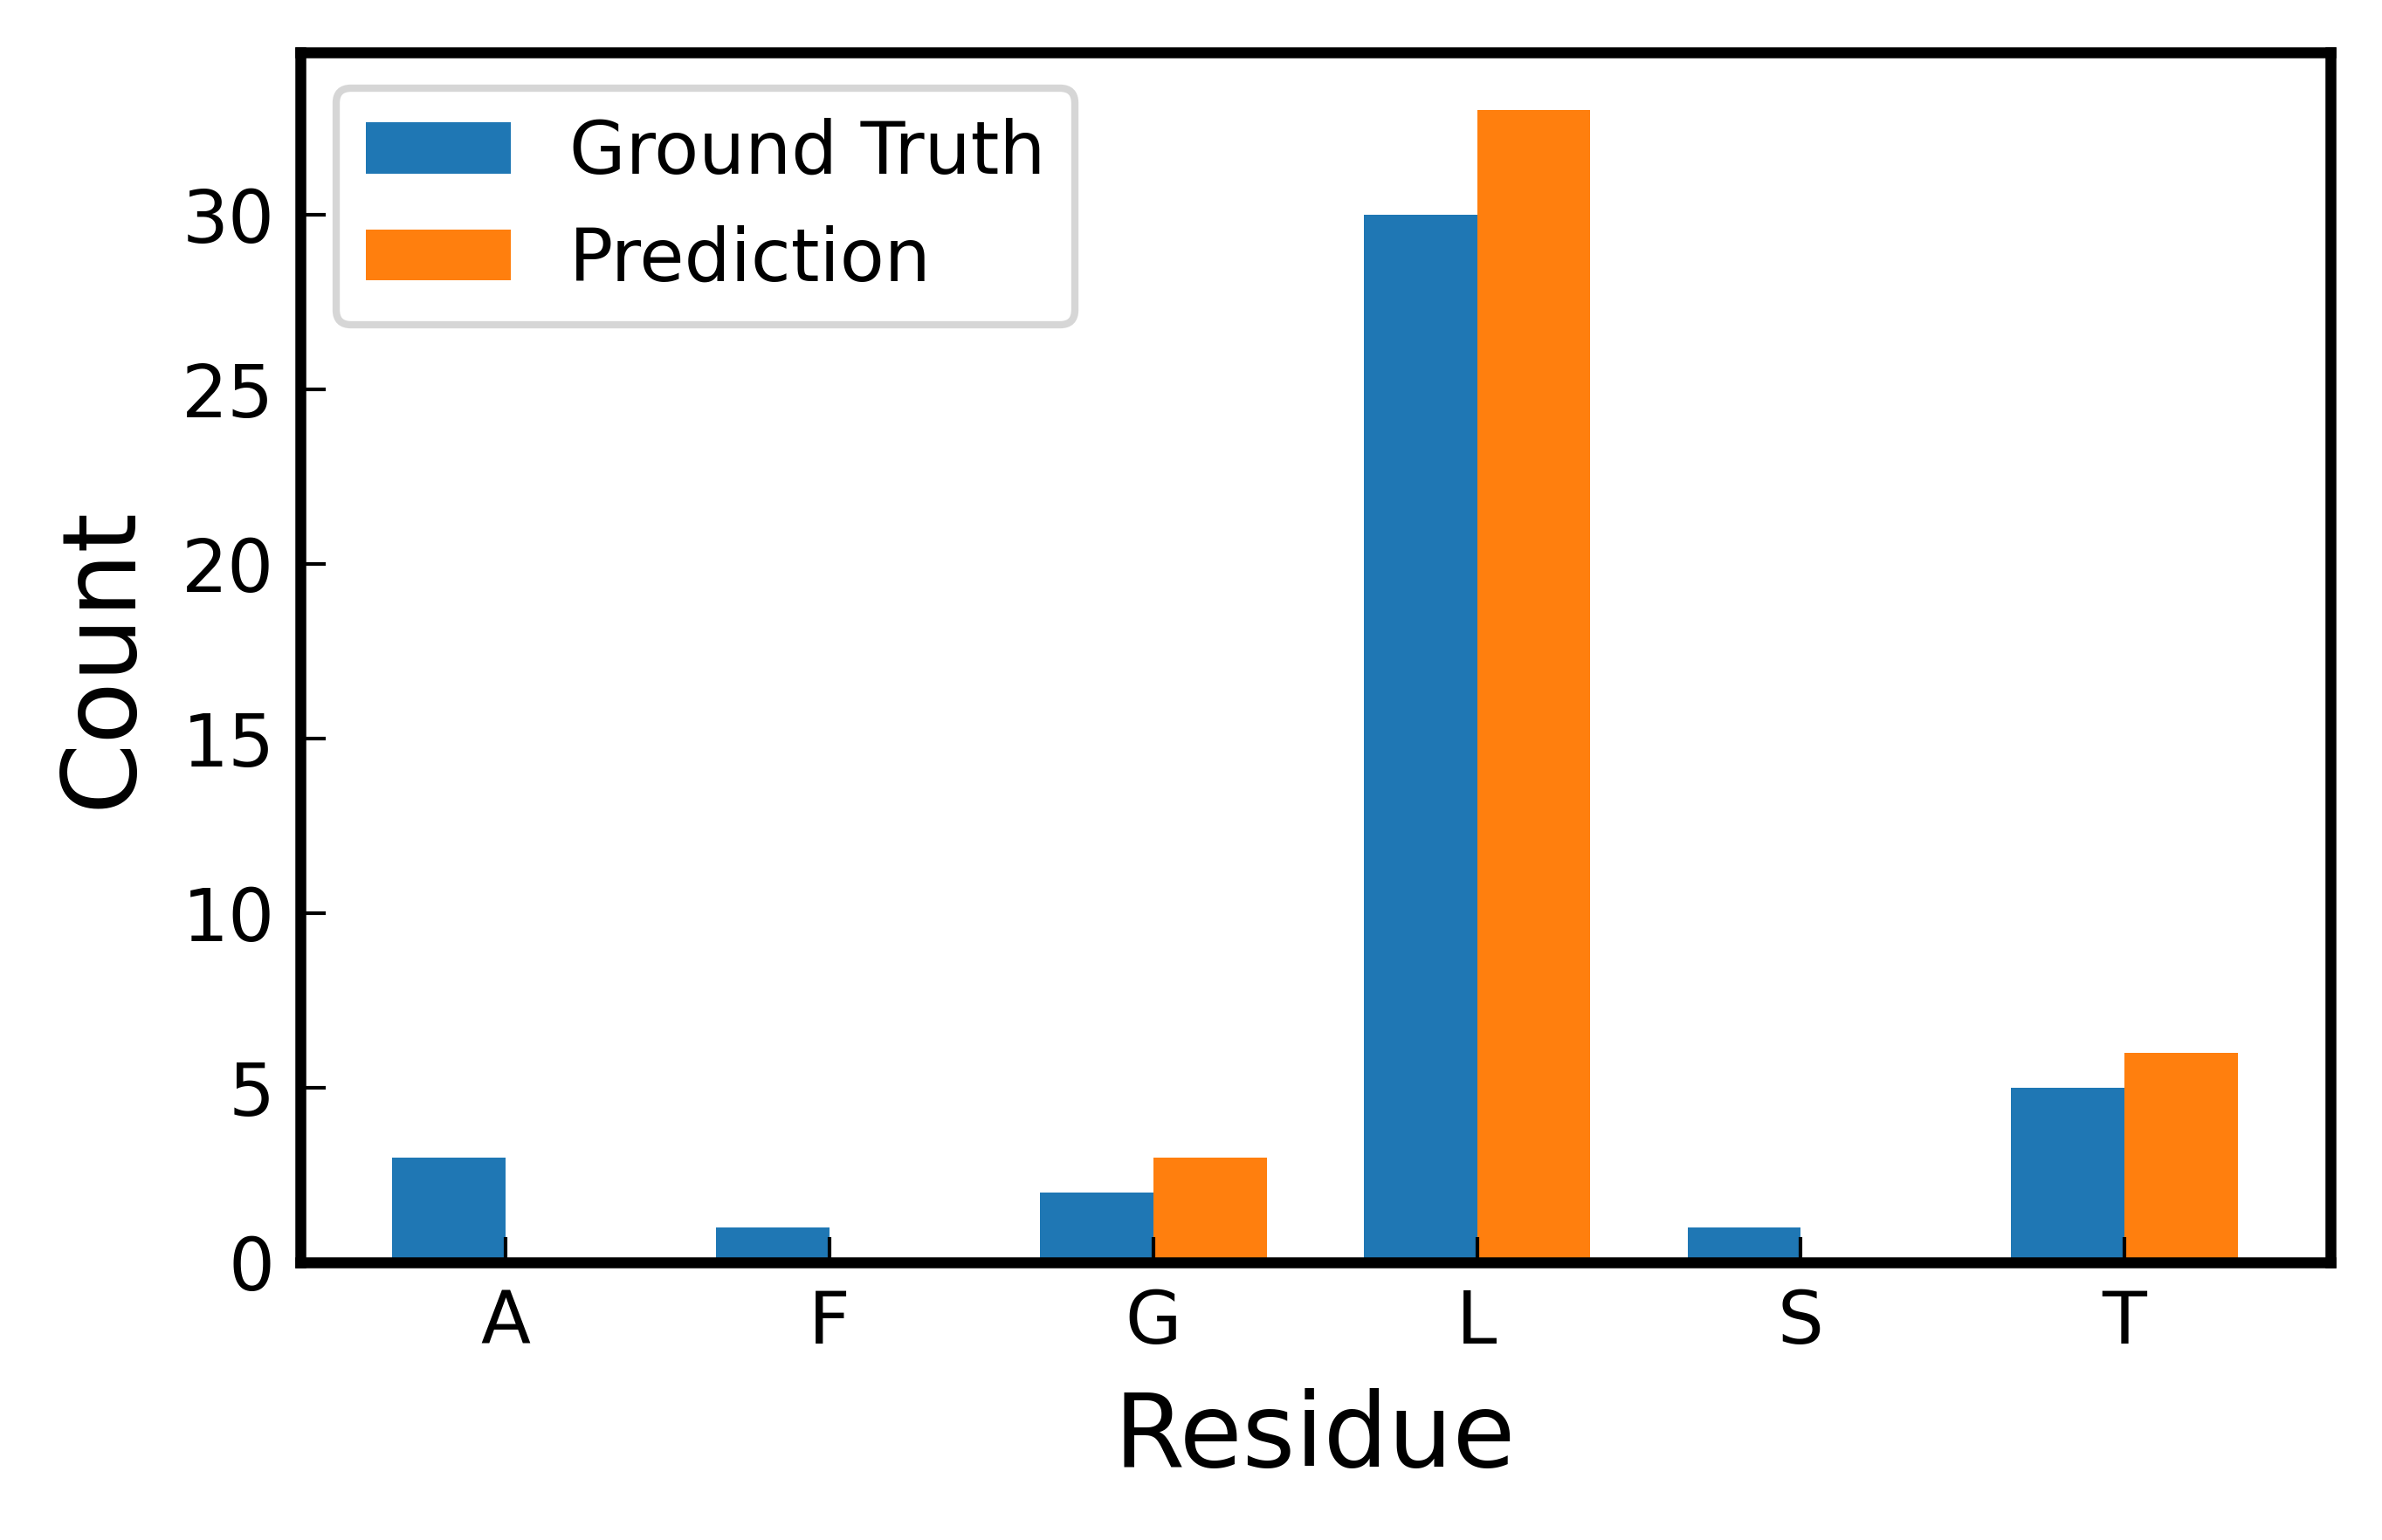

In [12]:
final_pred = pred.cpu().numpy()
final_gts = gts.cpu().numpy()

y_pred_amino = [index_to_amino_acid[i] for i in final_pred]
y_gts_amino = [index_to_amino_acid[i] for i in final_gts]

fig = bar_plot(y_gts_amino, y_pred_amino)

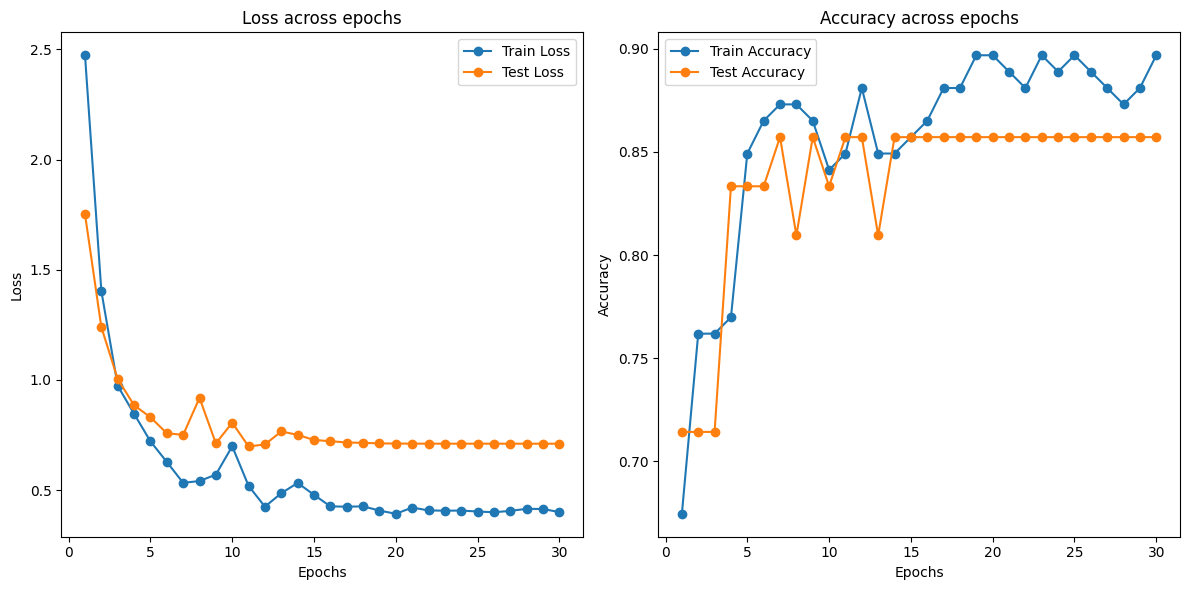

In [13]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), tr_ls, 'o-' ,label='Train Loss')
plt.plot(range(1, epochs+1), tt_ls, 'o-' , label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss across epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), tr_ac, 'o-' ,label='Train Accuracy')
plt.plot(range(1, epochs+1), tt_ac, 'o-' ,label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy across epochs')
plt.legend()

plt.tight_layout()
plt.show()